In [1]:
import pandas as pd, numpy as np
from db_queries import get_ids, get_outputs, get_location_metadata, get_population, get_covariate_estimates
from get_draws.api import get_draws
import scipy.stats 
import scipy.integrate as integrate
import matplotlib.pyplot as plt

In [2]:
import matplotlib.backends.backend_pdf

In [3]:
from mult_model_fns import *
from folic_acid_mult_model_fns import *

In [4]:
location_ids = [163,214,179]

ages = [1,2,3,4,5] # [49,50,51,52]
sexes = [1,2]
ages = [2,3,4,5]

draws = [f'draw_{i}' for i in range(1_000)]
index_cols=['location_id','sex_id','age_group_id']

# define alternative scenario coverage levels (low, medium, high)
    # this parameter represents the proportion of additional coverage achieved in the
    # alternative scenario, defined as the difference between the proportion of the population
    # that eats the fortified vehicle and the proportion of the population that eats 
    # the industrially produced vehicle
alternative_scenario_coverage_levels = [0.2, 0.5, 0.8]

In [5]:
rei_id = [] #folic acid doesn't effect any risks; just NTDs
cause_ids = [642] # NTDs
nonfatal_causes = [642] # YLLs and YLDs
nutrient = 'folic acid'
vehicle = 'wheat flour' 

In [6]:
# define no fortification relative risk distribution
# folic acid specific -- this should be replaced for other models

from numpy import log
from scipy.stats import norm, lognorm

# median and 0.975-quantile of lognormal distribution for RR
median = 1.71
q_975 = 2.04

# 0.975-quantile of standard normal distribution (=1.96, approximately)
q_975_stdnorm = norm().ppf(0.975)

mu = log(median) # mean of normal distribution for log(RR)
sigma = (log(q_975) - mu) / q_975_stdnorm # std dev of normal distribution for log(RR)

In [7]:
# calculate relative risk for lack of fortification
# https://vivarium-research.readthedocs.io/en/latest/concept_models/vivarium_conic_lsff/concept_model.html#effect-size-folic-acid
rr_ntds_nofort = format_rrs(lognormal_draws(mu, sigma, seed = 7), location_ids)
rr_ntds_nofort.mean(axis=1)

location_id
163    1.712028
214    1.712028
179    1.712028
dtype: float64

In [8]:
data = pull_coverage_data('/ihme/homes/beatrixh/vivarium_data_analysis', nutrient, vehicle, location_ids, 'wra')

In [9]:
data = create_marginal_uncertainty(data)

In [10]:
alpha, alpha_star = generate_coverage_tables(data, alternative_scenario_coverage_levels, seed = 11)

In [11]:
gets_intervn = prop_gets_intervention_effect(location_ids, year_start=2022, estimation_years = range(2022,2026))

In [12]:
new_coverage = percolate_new_coverage(gets_intervn, alpha, alpha_star)

In [13]:
paf_ntds_nofort = paf_o_r(rr_ntds_nofort, alpha)

In [14]:
pif_ntds_nofort = pif_o_r(paf_ntds_nofort, alpha = alpha, alpha_star = new_coverage)

In [15]:
dalys = pull_dalys(cause_ids, cause_ids, location_ids, ages, sexes, index_cols)

In [16]:
dalys_averted = calc_dalys_averted(dalys, pif_ntds_nofort)

In [17]:
dalys_averted_u5 = dalys_averted.reset_index().groupby(['location_id','year_id','coverage_level']).sum()[draws]

In [18]:
# collapse to summary stats
dalys_averted_u5['mean_value'] = dalys_averted_u5[[f'draw_{i}' for i in range(1_000)]].mean(axis=1)
dalys_averted_u5['p025'] = dalys_averted_u5[[f'draw_{i}' for i in range(1_000)]].quantile(.025, axis=1)
dalys_averted_u5['p975'] = dalys_averted_u5[[f'draw_{i}' for i in range(1_000)]].quantile(.975, axis=1)

dalys_averted_u5 = dalys_averted_u5[['mean_value','p025','p975']]

dalys_averted_u5 = dalys_averted_u5.reset_index()

In [19]:
## add rates
u5_pop = get_population(
    location_id=location_ids,
    year_id=2019,
    age_group_id=1,
    sex_id=3,
    gbd_round_id=6,
    decomp_step='step4'
)

dalys_averted_u5 = dalys_averted_u5.merge(u5_pop[['location_id','population']], on = 'location_id', how = 'left')

dalys_averted_u5['mean_dalys_per_100_000py'] = dalys_averted_u5.mean_value / dalys_averted_u5.population * 100_000
dalys_averted_u5['p025_dalys_per_100_000py'] = dalys_averted_u5.p025 / dalys_averted_u5.population * 100_000
dalys_averted_u5['p975_dalys_per_100_000py'] = dalys_averted_u5.p975 / dalys_averted_u5.population * 100_000

# viz results

In [20]:
# coverage_level_dict = {0.2:'low',0.5:'medium',0.8:'high'}
# dalys_averted_u5.coverage_level = dalys_averted_u5.coverage_level.map(coverage_level_dict)

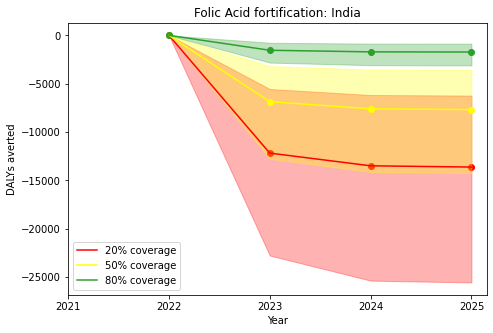

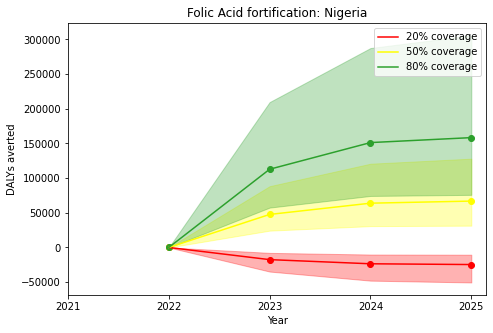

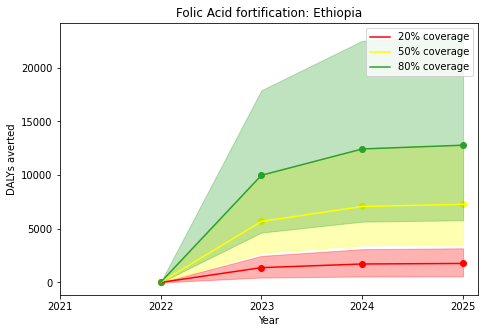

In [21]:
def plot_dalys_averted_by_country(save_path):
    pdf = matplotlib.backends.backend_pdf.PdfPages(save_path)
    location_names = {
        179:"Ethiopia",
        163:"India",
        214:"Nigeria",
        205:"Côte d'Ivoire",
        190:"Uganda",
        189:"United Republic of Tanzania"
    }
    colors = {0.8: 'tab:green', 0.5:'yellow', 0.2: 'red'}
    
    for loc in [163,214,179]:
        fig, ax = plt.subplots(figsize=(7.5, 5))
        for level in alternative_scenario_coverage_levels:
            
            plt.scatter(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                       dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].mean_value, color = colors[level])
            plt.plot(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                       dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].mean_value,  color = colors[level], label = f'{int(level*100)}% coverage')
            plt.fill_between(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                             dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].p975,
                             dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].p025, alpha=0.3, color = colors[level])
            plt.ylabel('DALYs averted')
            plt.xlabel('Year')
            plt.title(f'Folic Acid fortification: {location_names[loc]}')
            plt.legend()
            plt.xticks([2021,2022,2023,2024,2025], [2021,2022,2023,2024,2025])
        pdf.savefig(fig)
    
    plt.show()
    pdf.close()

save_path = '/ihme/homes/beatrixh/repos/scratch/test.pdf'    
plot_dalys_averted_by_country(save_path)


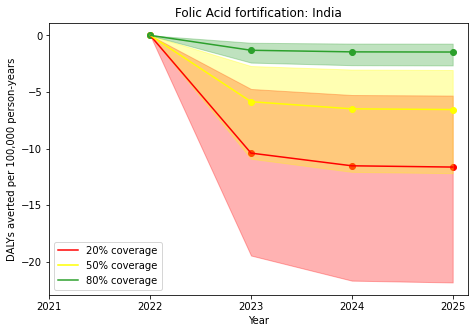

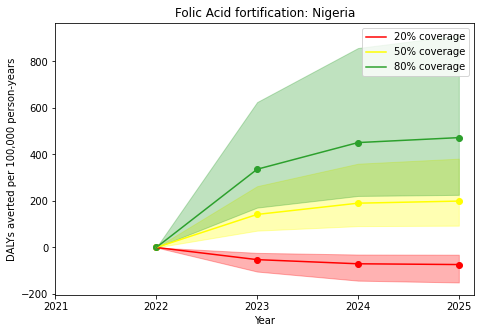

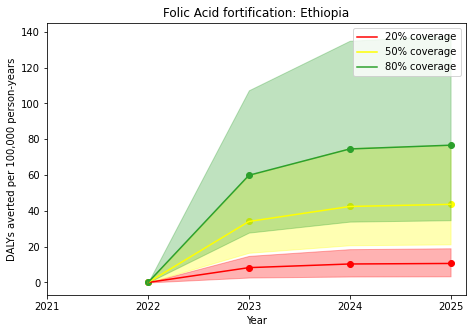

In [22]:
def plot_dalys_averted_per_100_000py_by_country(save_path):
    pdf = matplotlib.backends.backend_pdf.PdfPages(save_path)
    location_names = {
        179:"Ethiopia",
        163:"India",
        214:"Nigeria",
        205:"Côte d'Ivoire",
        190:"Uganda",
        189:"United Republic of Tanzania"
    }
    colors = {0.8: 'tab:green', 0.5:'yellow', 0.2: 'red'}    
    for loc in [163,214,179]:
        fig, ax = plt.subplots(figsize=(7.5, 5))
        for level in alternative_scenario_coverage_levels:
            
            plt.scatter(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                       dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].mean_dalys_per_100_000py, color = colors[level])
            plt.plot(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                       dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].mean_dalys_per_100_000py,  color = colors[level], label = f'{int(level*100)}% coverage')
            plt.fill_between(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                             dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].p975_dalys_per_100_000py,
                             dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].p025_dalys_per_100_000py, alpha=0.3, color = colors[level])
            plt.ylabel('DALYs averted per 100,000 person-years')
            plt.xlabel('Year')
            plt.title(f'Folic Acid fortification: {location_names[loc]}')
            plt.legend()
            plt.xticks([2021,2022,2023,2024,2025], [2021,2022,2023,2024,2025])
        pdf.savefig(fig)
    
    plt.show()
    pdf.close()

save_path = '/ihme/homes/beatrixh/repos/scratch/test.pdf'    
plot_dalys_averted_per_100_000py_by_country(save_path)


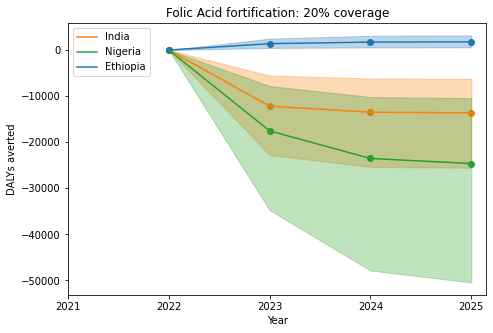

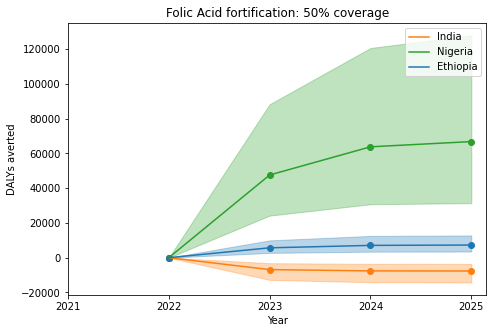

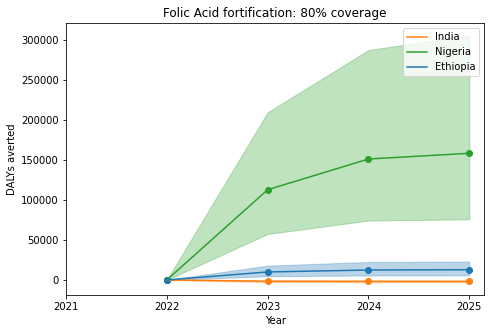

In [23]:
def plot_dalys_averted(save_path):
    pdf = matplotlib.backends.backend_pdf.PdfPages(save_path)
    location_names = {
        179:"Ethiopia",
        163:"India",
        214:"Nigeria",
        205:"Côte d'Ivoire",
        190:"Uganda",
        189:"United Republic of Tanzania"
    }
    colors = {179: 'tab:blue', 163: 'tab:orange', 214: 'tab:green', 205: 'yellow', 189:'purple'}

    for level in alternative_scenario_coverage_levels:
        fig, ax = plt.subplots(figsize=(7.5, 5))
        for loc in [163,214,179]:
            
            plt.scatter(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                       dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].mean_value, color = colors[loc])
            plt.plot(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                       dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].mean_value,  color = colors[loc], label = location_names[loc])
            plt.fill_between(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                             dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].p975,
                             dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].p025, alpha=0.3, color = colors[loc])
            plt.ylabel('DALYs averted')
            plt.xlabel('Year')
            plt.title(f'Folic Acid fortification: {int(level*100)}% coverage')
            plt.legend()
            plt.xticks([2021,2022,2023,2024,2025], [2021,2022,2023,2024,2025])
        pdf.savefig(fig)
    
    plt.show()
    pdf.close()

save_path = '/ihme/homes/beatrixh/repos/scratch/fa_dalys_averted_absolute.pdf'    
plot_dalys_averted(save_path)


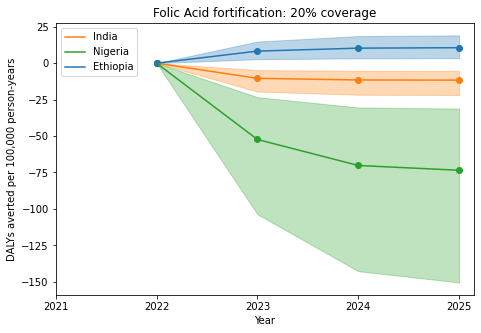

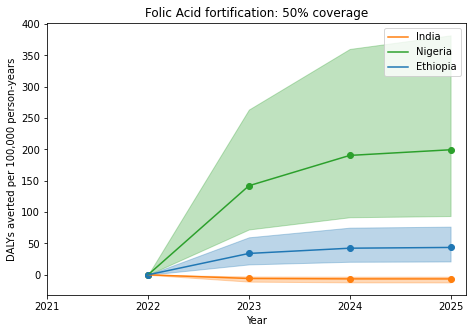

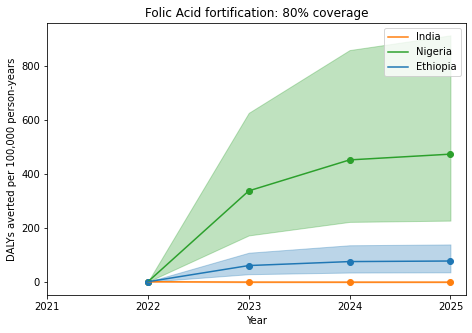

In [24]:
def plot_dalys_averted_rate(save_path):
    pdf = matplotlib.backends.backend_pdf.PdfPages(save_path)
    location_names = {
        179:"Ethiopia",
        163:"India",
        214:"Nigeria",
        205:"Côte d'Ivoire",
        190:"Uganda",
        189:"United Republic of Tanzania"
    }
    colors = {179: 'tab:blue', 163: 'tab:orange', 214: 'tab:green', 205: 'yellow', 189:'purple'}

    for level in alternative_scenario_coverage_levels:
        fig, ax = plt.subplots(figsize=(7.5, 5))
        for loc in [163,214,179]:
    #     for loc in [163]:

            plt.scatter(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                       dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].mean_dalys_per_100_000py, color = colors[loc])
            plt.plot(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                       dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].mean_dalys_per_100_000py,  color = colors[loc], label = location_names[loc])
            plt.fill_between(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                             dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].p975_dalys_per_100_000py,
                             dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].p025_dalys_per_100_000py, alpha=0.3, color = colors[loc])
            plt.ylabel('DALYs averted per 100,000 person-years')
            plt.xlabel('Year')
            plt.title(f'Folic Acid fortification: {int(level*100)}% coverage')
            plt.legend()
            plt.xticks([2021,2022,2023,2024,2025], [2021,2022,2023,2024,2025])
        pdf.savefig(fig)

    plt.show()
    pdf.close()

save_path = '/ihme/homes/beatrixh/repos/scratch/fa_dalys_averted_rate.pdf'    
plot_dalys_averted_rate(save_path)